In [1]:
import OpenEXR
import Imath
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset

In [2]:
import OpenEXR
import Imath
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from pathlib import Path

class EXRSequenceDataset(Dataset):
    """
    Loads fixed-length ConvLSTM sequences from EXR files named <seq>_<t>.exr.
    Each sequence must have at least input_length + output_length frames.

    Args:
        root_dir (str or Path): directory containing 'Inputs' subfolder
        input_length (int): number of past frames to use as input (e.g. 5)
        output_length (int): number of future frames to predict (e.g. 5)
        transform (callable): fn(seq_tensor, tgt_tensor) -> (seq, tgt)

    Returns:
        seq: Tensor of shape (input_length, 4, H, W)
        tgt: Tensor of shape (output_length, 4, H, W)
    """
    def __init__(self, root_dir, input_length=5, output_length=5, transform=None):
        self.inputs_dir = Path(root_dir) / "Inputs"
        self.input_length = input_length
        self.output_length = output_length
        self.seq_len = input_length + output_length
        self.transform = transform

        # Gather and group files by sequence index
        files = sorted(self.inputs_dir.glob("*.exr"))
        seq_dict = {}
        for f in files:
            stem = f.stem  # e.g. '0_3'
            if '_' not in stem:
                continue
            seq_id, t = stem.split('_', 1)
            try:
                sid = int(seq_id)
                ti = int(t)
            except:
                continue
            seq_dict.setdefault(sid, []).append((ti, f))

        # Build valid sequences
        self.sequences = []
        for sid in sorted(seq_dict.keys()):
            frames = sorted(seq_dict[sid], key=lambda x: x[0])
            if len(frames) < self.seq_len:
                continue
            # Only take the first seq_len frames
            paths = [p for (_, p) in frames[:self.seq_len]]
            self.sequences.append(paths)

        # Pixel type for float32 EXR
        self.pt = Imath.PixelType(Imath.PixelType.FLOAT)

    def __len__(self):
        return len(self.sequences)

    def _read_exr(self, path):
        exr = OpenEXR.InputFile(str(path))
        dw = exr.header()['dataWindow']
        w, h = dw.max.x - dw.min.x + 1, dw.max.y - dw.min.y + 1
        channels = []
        for c in ['R','G','B','A']:
            buf = exr.channel(c, self.pt)
            arr = np.frombuffer(buf, dtype=np.float32).reshape(h, w)
            channels.append(arr)
        return np.stack(channels, axis=0)

    def __getitem__(self, idx):
        paths = self.sequences[idx]
        # First input_length for inputs, next output_length for targets
        inp_paths = paths[:self.input_length]
        out_paths = paths[self.input_length:self.seq_len]

        # Read and stack
        seq_np = [self._read_exr(p) for p in inp_paths]
        seq_np = np.stack(seq_np, axis=0)  # (T_in,4,H,W)
        tgt_np = [self._read_exr(p) for p in out_paths]
        tgt_np = np.stack(tgt_np, axis=0)  # (T_out,4,H,W)

        seq = torch.from_numpy(seq_np).float()
        tgt = torch.from_numpy(tgt_np).float()

        if self.transform:
            seq, tgt = self.transform(seq, tgt)

        return seq, tgt


def load_dataset(path, batch_size, input_length=5, output_length=5,
                  train_split=0.8, val_split=0.1,
                  shuffle=True, num_workers=0,
                  transform=None, print_validation=False):
    """
    Creates train/val/test DataLoaders for EXRSequenceDataset with fixed input/output lengths.

    Prints dataset and loader sizes if print_validation is True.
    """
    ds = EXRSequenceDataset(path,
                             input_length=input_length,
                             output_length=output_length,
                             transform=transform)
    total = len(ds)
    if train_split + val_split >= 1.0:
        raise ValueError("train_split + val_split must be < 1.0")

    n_train = int(total * train_split)
    n_val = int(total * val_split)
    n_test = total - n_train - n_val

    train_ds, val_ds, test_ds = torch.utils.data.random_split(
        ds, [n_train, n_val, n_test],
        generator=torch.Generator().manual_seed(42)
    )

    train_loader = DataLoader(train_ds, batch_size=batch_size,
                              shuffle=shuffle, num_workers=num_workers,
                              pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size,
                            shuffle=False, num_workers=num_workers,
                            pin_memory=True)
    test_loader = DataLoader(test_ds, batch_size=batch_size,
                             shuffle=False, num_workers=num_workers,
                             pin_memory=True)

    if print_validation:
        print(f"Total seqs: {total}, input_length={input_length}, output_length={output_length}")
        print(f"Train: {n_train} seqs, {len(train_loader)} batches @ bs={batch_size}")
        print(f"Val:   {n_val} seqs, {len(val_loader)} batches")
        print(f"Test:  {n_test} seqs, {len(test_loader)} batches")
        for name, loader in zip(['Train','Val','Test'], [train_loader,val_loader,test_loader]):
            seq, tgt = next(iter(loader))
            print(f"{name} batch: seq {seq.shape}, tgt {tgt.shape}")

    return train_loader, val_loader, test_loader

# Example joint transform:
#
# def normalize_and_flip(seq, tgt):
#     # Example: normalize from [-10,10] to [-1,1]
#     seq = seq / 10.0
#     tgt = tgt / 10.0
#     # random flips
#     if torch.rand(1) < 0.5:
#         seq = torch.flip(seq, dims=[3]); tgt = torch.flip(tgt, dims=[2])
#     if torch.rand(1) < 0.5:
#         seq = torch.flip(seq, dims=[2]); tgt = torch.flip(tgt, dims=[1])
#     return seq, tgt
#
# Usage:
# train_loader, val_loader, test_loader = load_dataset(
#     '/path/to/dataset', batch_size=4,
#     input_length=5, output_length=5,
#     transform=normalize_and_flip,
#     print_validation=True
# )


In [3]:
# path = Path("C:/Users/epuls/OneDrive/Desktop/dataT/")
# tr,vl,tst = load_dataset(path, batch_size=4, input_length=5, output_length=5, print_validation=True)

In [4]:
torch.manual_seed(42)
class ConvLSTMCell(nn.Module):
    def __init__(self, in_ch, hid_ch, k):
        super().__init__()
        pad = k // 2
        self.hid_ch = hid_ch
        self.conv = nn.Conv2d(in_ch + hid_ch, 4 * hid_ch, k, padding=pad)

    def forward(self, x, h, c):
        combined = torch.cat([x, h], dim=1)
        cc_i, cc_f, cc_o, cc_g = torch.chunk(self.conv(combined), 4, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)
        c_next = f * c + i * g
        h_next = o * torch.tanh(c_next)
        return h_next, c_next

# Seq2Seq ConvLSTM Model for multi-step outputs
class ConvLSTMSeq2Seq(nn.Module):
    def __init__(self, in_ch=4, hid_chs=[64,64], ks=[3,3], output_length=5):
        super().__init__()
        assert len(hid_chs) == len(ks), "hid_chs and ks must match lengths"
        self.cells = nn.ModuleList()
        ch = in_ch
        for h, k in zip(hid_chs, ks):
            self.cells.append(ConvLSTMCell(ch, h, k))
            ch = h
        self.output_length = output_length
        self.conv_out = nn.Conv2d(ch, in_ch, 1)

    def forward(self, x):
        # x: (B, T_in, C, H, W)
        B, T, C, H, W = x.size()
        # initialize hidden states
        hs = [torch.zeros(B, cell.hid_ch, H, W, device=x.device) for cell in self.cells]
        cs = [torch.zeros_like(h) for h in hs]

        # encoding
        for t in range(T):
            inp = x[:, t]
            for i, cell in enumerate(self.cells):
                hs[i], cs[i] = cell(inp, hs[i], cs[i])
                inp = hs[i]

        # decoding (autoregressive)
        outputs = []
        prev = x[:, -1]  # start with last input frame
        for _ in range(self.output_length):
            inp = prev
            for i, cell in enumerate(self.cells):
                hs[i], cs[i] = cell(inp, hs[i], cs[i])
                inp = hs[i]
            out = self.conv_out(inp)  # (B, C, H, W)
            outputs.append(out)
            prev = out

        return torch.stack(outputs, dim=1)  # (B, T_out, C, H, W)
    

def test_model_dummy(model, device='cpu', batch_size=1,
                     input_length=5, channels=4, height=256, width=256):
    """
    Create a dummy batch of random data to verify model output shapes.
    """
    model.to(device)
    model.eval()
    # Dummy input: (B, T_in, C, H, W)
    dummy_seq = torch.randn(batch_size, input_length, channels, height, width, device=device)
    print(f'dummy_seq shape: {dummy_seq.shape}')
    with torch.no_grad():
        output = model(dummy_seq)
    print(f"Dummy input shape: {dummy_seq.shape}")
    print(f"Model output shape: {output.shape}")
    return output

# test_model_dummy(ConvLSTMSeq2Seq(), device='cuda', batch_size=1)


In [5]:
def convert_exrseq_to_pt(root_dir, pt_dir, input_length=5, output_length=5, transform=None):
    """
    Converts all sequences in EXRSequenceDataset to individual .pt files.

    Args:
        root_dir (str | Path): path to dataset root containing 'Inputs' folder.
        pt_dir   (str | Path): where to save .pt files (one per sequence).
        input_length (int): number of input frames.
        output_length(int): number of target frames.
        transform (callable): optional joint transform to apply.

    Output:
        Saves files named 'seq_{i}.pt' in pt_dir, each containing a tuple (seq, tgt).
    """
    import os
    from pathlib import Path
    pt_path = Path(pt_dir)
    pt_path.mkdir(parents=True, exist_ok=True)

    dataset = EXRSequenceDataset(root_dir, input_length, output_length, transform)
    for idx in range(len(dataset)):
        seq, tgt = dataset[idx]
        save_path = pt_path / f"seq_{idx}.pt"
        torch.save({
            'sequence': seq,
            'target': tgt
        }, str(save_path))
    print(f"Saved {len(dataset)} sequences to {pt_dir}")



In [6]:
def train_model_seq2seq(model, train_loader, val_loader, criterion, optimizer,
                        num_epochs, device, threshold=0.01):
    """
    Train the Seq2Seq ConvLSTM model over multiple epochs, printing loss and accuracy.

    Accuracy is fraction of pixels across all output frames within `threshold`.
    """
    model.to(device)
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        for seq, tgt in train_loader:
            seq = seq.to(device)
            tgt = tgt.to(device)  # shape (B, T_out, C, H, W)
            optimizer.zero_grad()
            out = model(seq)     # shape (B, T_out, C, H, W)
            loss = criterion(out, tgt)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * seq.size(0)
            diff = torch.abs(out - tgt)
            train_correct += (diff < threshold).float().sum().item()
            train_total += diff.numel()

        train_loss /= len(train_loader.dataset)
        train_acc = train_correct / train_total

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for seq, tgt in val_loader:
                seq = seq.to(device)
                tgt = tgt.to(device)
                out = model(seq)
                loss = criterion(out, tgt)
                val_loss += loss.item() * seq.size(0)
                diff = torch.abs(out - tgt)
                val_correct += (diff < threshold).float().sum().item()
                val_total += diff.numel()
        val_loss /= len(val_loader.dataset)
        val_acc = val_correct / val_total

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {train_loss:.6f}, Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.6f}, Acc: {val_acc:.4f}")

    return model

In [7]:
def test_and_plot_seq2seq(model, test_loader, device, threshold=0.01):
    """
    Evaluate model on test set, print loss/accuracy, then plot:
      - Row 1: input frames
      - Row 2: target frames
      - Row 3: predicted frames
    """
    model.to(device)
    model.eval()

    # Compute loss/accuracy
    total_loss = 0.0
    total_correct = 0
    total_pixels = 0
    criterion = nn.MSELoss()
    with torch.no_grad():
        for seq, tgt in test_loader:
            seq = seq.to(device)
            tgt = tgt.to(device)
            out = model(seq)
            loss = criterion(out, tgt)
            total_loss += loss.item() * seq.size(0)
            diff = torch.abs(out - tgt)
            total_correct += (diff < threshold).float().sum().item()
            total_pixels += diff.numel()
    test_loss = total_loss / len(test_loader.dataset)
    test_acc = total_correct / total_pixels
    print(f"Test Loss: {test_loss:.6f}, Acc: {test_acc:.4f}")

    # Plot a random sample
    seq_batch, tgt_batch = next(iter(test_loader))
    seq = seq_batch[0].to(device)   # (T_in, C, H, W)
    tgt = tgt_batch[0].to(device)   # (T_out, C, H, W)
    out = model(seq_batch.to(device))[0]  # (T_out, C, H, W)

    T_in = seq.size(0)
    T_out = tgt.size(0)
    seq_np = seq.permute(0,2,3,1).cpu().numpy()
    tgt_np = tgt.permute(0,2,3,1).cpu().numpy()
    out_np = out.permute(0,2,3,1).cpu().numpy()

    fig, axes = plt.subplots(3, max(T_in, T_out), figsize=(4*max(T_in,T_out), 12))
    # Row 1: inputs
    for i in range(T_in):
        axes[0,i].imshow(np.clip(seq_np[i], 0.0, 1.0))
        axes[0,i].set_title(f"In {i}")
        axes[0,i].axis('off')
    # Row 2: targets
    for j in range(T_out):
        axes[1,j].imshow(np.clip(tgt_np[j], 0.0, 1.0))
        axes[1,j].set_title(f"Target {j}")
        axes[1,j].axis('off')
    # Row 3: predictions
    for j in range(T_out):
        axes[2,j].imshow(np.clip(out_np[j], 0.0, 1.0))
        axes[2,j].set_title(f"Pred {j}")
        axes[2,j].axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
path = Path("C:/Users/epuls/OneDrive/Desktop/E2/")
dest = Path("C:/Users/epuls/OneDrive/Desktop/E2/pt_sim_comp/")
convert_exrseq_to_pt(path, dest, input_length=5, output_length=5)

Saved 100 sequences to C:\Users\epuls\OneDrive\Desktop\E2\test_pt_hard


Total PT seqs: 500
Train: 400 sequences, 100 batches @ bs=4
Val:   50 sequences, 13 batches
Test:  50 sequences, 13 batches
Train batch shapes: seq torch.Size([4, 5, 4, 256, 256]), tgt torch.Size([4, 5, 4, 256, 256])
Val batch shapes: seq torch.Size([4, 5, 4, 256, 256]), tgt torch.Size([4, 5, 4, 256, 256])
Test batch shapes: seq torch.Size([4, 5, 4, 256, 256]), tgt torch.Size([4, 5, 4, 256, 256])


C:\Users\epuls\AppData\Local\Temp\ipykernel_19296\2866005989.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(str(self.files[idx]))


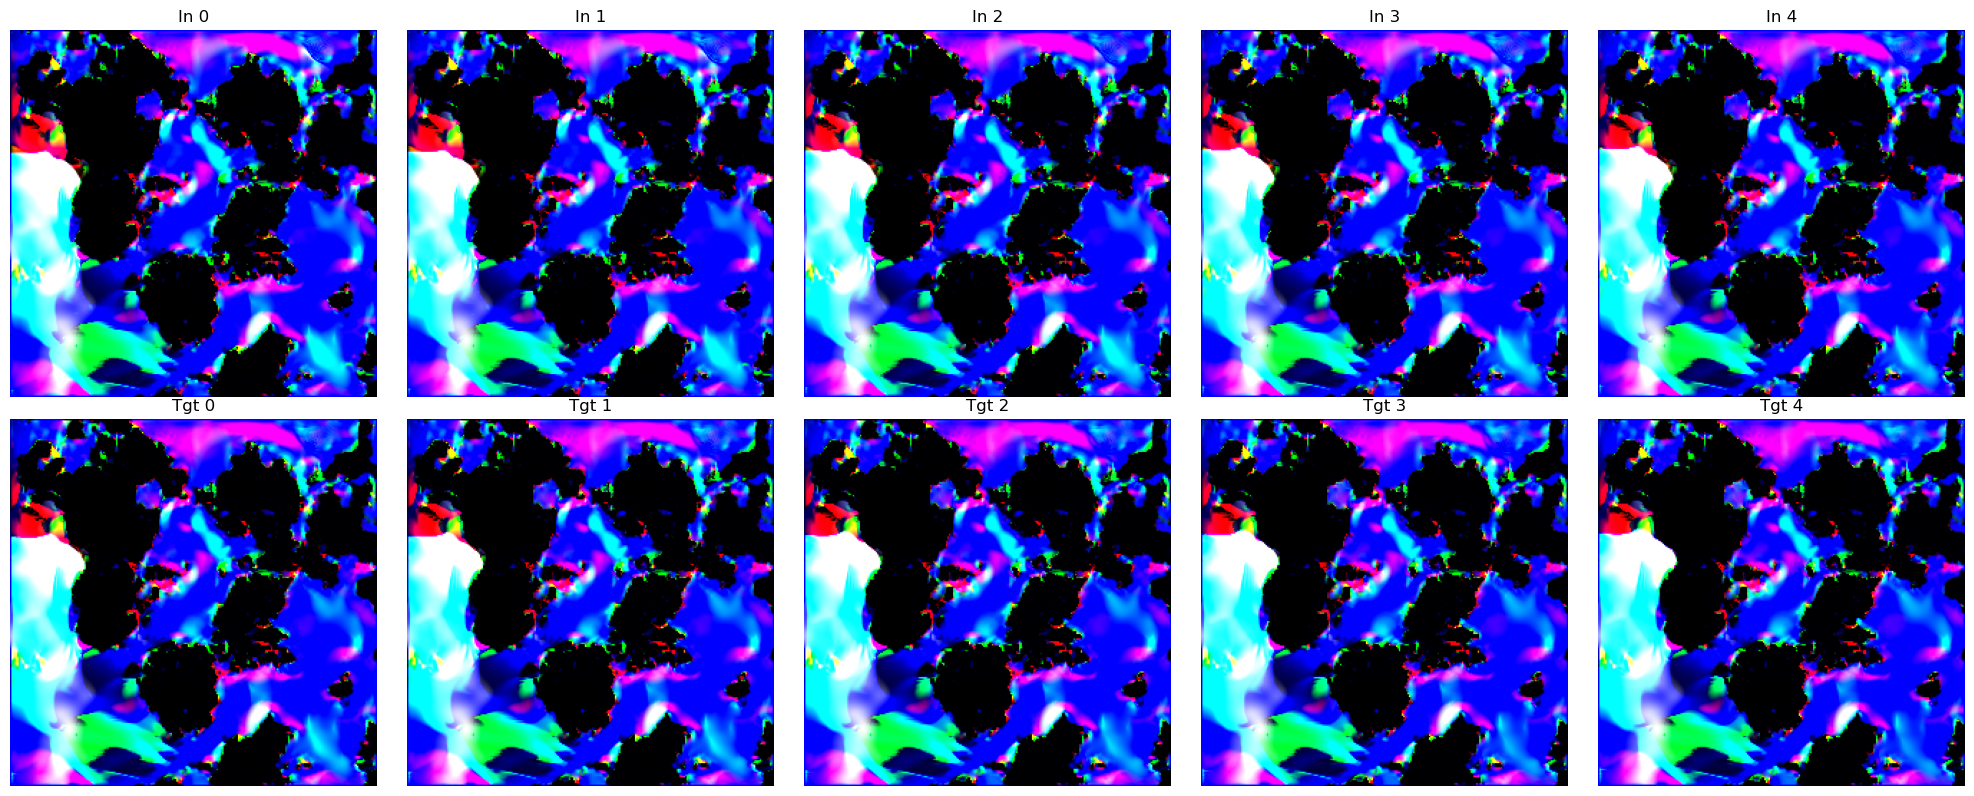

In [20]:
class PTSequenceDataset(Dataset):
    """
    Loads pre-saved .pt sequence files with keys 'sequence' and 'target'.
    """
    def __init__(self, pt_dir, transform=None):
        self.files = sorted(Path(pt_dir).glob('seq_*.pt'))
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        data = torch.load(str(self.files[idx]))
        seq = data['sequence']  # (T_in, C, H, W)
        tgt = data['target']    # (T_out, C, H, W)
        if self.transform:
            seq, tgt = self.transform(seq, tgt)
        return seq, tgt


def load_pt_dataset(pt_dir, batch_size, train_split=0.8, val_split=0.1,
                    shuffle=True, num_workers=0, pin_memory=False, transform=None, print_validation=False):
    """
    Load .pt sequence dataset and return train/val/test DataLoaders.
    """
    ds = PTSequenceDataset(pt_dir, transform)
    total = len(ds)
    n_train = int(total * train_split)
    n_val = int(total * val_split)
    n_test = total - n_train - n_val
    train_ds, val_ds, test_ds = torch.utils.data.random_split(
        ds, [n_train, n_val, n_test], generator=torch.Generator().manual_seed(42)
    )
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=shuffle,
                              num_workers=num_workers, pin_memory=pin_memory)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False,
                              num_workers=num_workers, pin_memory=pin_memory)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False,
                              num_workers=num_workers, pin_memory=pin_memory)

    if print_validation:
        print(f"Total PT seqs: {total}")
        print(f"Train: {n_train} sequences, {len(train_loader)} batches @ bs={batch_size}")
        print(f"Val:   {n_val} sequences, {len(val_loader)} batches")
        print(f"Test:  {n_test} sequences, {len(test_loader)} batches")
        for name, loader in zip(['Train','Val','Test'], [train_loader, val_loader, test_loader]):
            seq, tgt = next(iter(loader))
            print(f"{name} batch shapes: seq {seq.shape}, tgt {tgt.shape}")

    return train_loader, val_loader, test_loader


def plot_random_pt_sample(dataset):
    """
    Randomly pick a sample from a PTSequenceDataset and plot inputs and targets.

    Row 1: input frames
    Row 2: target frames
    """
    idx = np.random.randint(len(dataset))
    seq, tgt = dataset[idx]  # seq: (T_in, C, H, W), tgt: (T_out, C, H, W)
    T_in, C, H, W = seq.shape
    T_out = tgt.shape[0]
    seq_np = seq.permute(0,2,3,1).numpy()
    tgt_np = tgt.permute(0,2,3,1).numpy()

    # create subplots
    fig, axes = plt.subplots(2, max(T_in, T_out), figsize=(4*max(T_in,T_out), 8))
    # inputs
    for t in range(T_in):
        axes[0,t].imshow(np.clip(seq_np[t], 0.0, 1.0))
        axes[0,t].set_title(f"In {t}")
        axes[0,t].axis('off')
    # targets
    for t in range(T_out):
        axes[1,t].imshow(np.clip(tgt_np[t], 0.0, 1.0))
        axes[1,t].set_title(f"Tgt {t}")
        axes[1,t].axis('off')
    plt.tight_layout()
    plt.show()


train_loader, val_loader, test_loader = load_pt_dataset(dest, batch_size=4, print_validation=True)
dataset_pt = PTSequenceDataset(dest)
plot_random_pt_sample(dataset_pt)

In [21]:
def normalize(seq, tgt):
    seq = seq/10
    tgt = tgt/10
    return seq, tgt

train_loader, val_loader, test_loader = load_pt_dataset(dest, batch_size=4, num_workers=0, transform=normalize,print_validation=True)
model = ConvLSTMSeq2Seq().to('cuda')
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
trained = train_model_seq2seq(model, train_loader, val_loader, criterion, optimizer,num_epochs=10, device='cuda')

Total PT seqs: 500
Train: 400 sequences, 100 batches @ bs=4
Val:   50 sequences, 13 batches
Test:  50 sequences, 13 batches
Train batch shapes: seq torch.Size([4, 5, 4, 256, 256]), tgt torch.Size([4, 5, 4, 256, 256])
Val batch shapes: seq torch.Size([4, 5, 4, 256, 256]), tgt torch.Size([4, 5, 4, 256, 256])
Test batch shapes: seq torch.Size([4, 5, 4, 256, 256]), tgt torch.Size([4, 5, 4, 256, 256])


C:\Users\epuls\AppData\Local\Temp\ipykernel_19296\2866005989.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(str(self.files[idx]))


Epoch 1/10 | Train Loss: 0.026910, Acc: 0.1690 | Val Loss: 0.004241, Acc: 0.3231
Epoch 2/10 | Train Loss: 0.003486, Acc: 0.4026 | Val Loss: 0.003151, Acc: 0.3369


KeyboardInterrupt: 

In [22]:
torch.save(trained.state_dict(), 'model.pth')

NameError: name 'trained' is not defined